<a href="https://colab.research.google.com/github/edwardoughton/spatial_computing/blob/main/10_01_Shortest_Path_Routing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shortest-Path Routing

Welcome to this class on shortest-path routing.

Today we will cover some basic introductory graph theory, followed by covering Kruskal's algorithm, eventually fitting our own minimum spanning tree.


## Introduction to graph theory

Before we get into some code, we need to briefly cover some introductory graph theory.

Here, we treat a 'graph' as representing a set of relationships between objects. Think of a network of cities, with roads between them, each having a specific distance.

This field provides a mathematical framework for spatial problems by treating phenomena of interest as networks (e.g., a graph).

The nodes in the network are known as "vertices", which are then linked by graph connections called "edges" (so cities would be the nodes, and roads would be the edges).

Such an approach supports a wide variety of spatial computing applications pertaining to the modeling, analyzing, and solving of spatial problems. We have already covered in this class that understanding spatial relationships is central to spatial computing.

* A **graph** (G) consists of a set of **vertices** (V) and a set of **edges** (E), where each edge connects a pair of vertices. We are able to measure graph networks based on different properties, including (i) directed vs. undirected, (ii) connected vs. disconnected, and (iii) weighted vs. unweighted edges.
* Whether or not vertices are directly connected or not by an edge is referred to as **adjacency**. The degree of adjacency is symmetric in undirected graphs.
* When we have a sequence of vertices connected by edges, this is called a "path". This indicates a possible way to traverse from one vertex node to another, along a particular set of edges.


By way of an illustrative example, the figure below shows how a graph theory approach could be applied to understand the neurons in our brains, through to a social network (Figures are credited to Haque and Andrejevic, 2021).



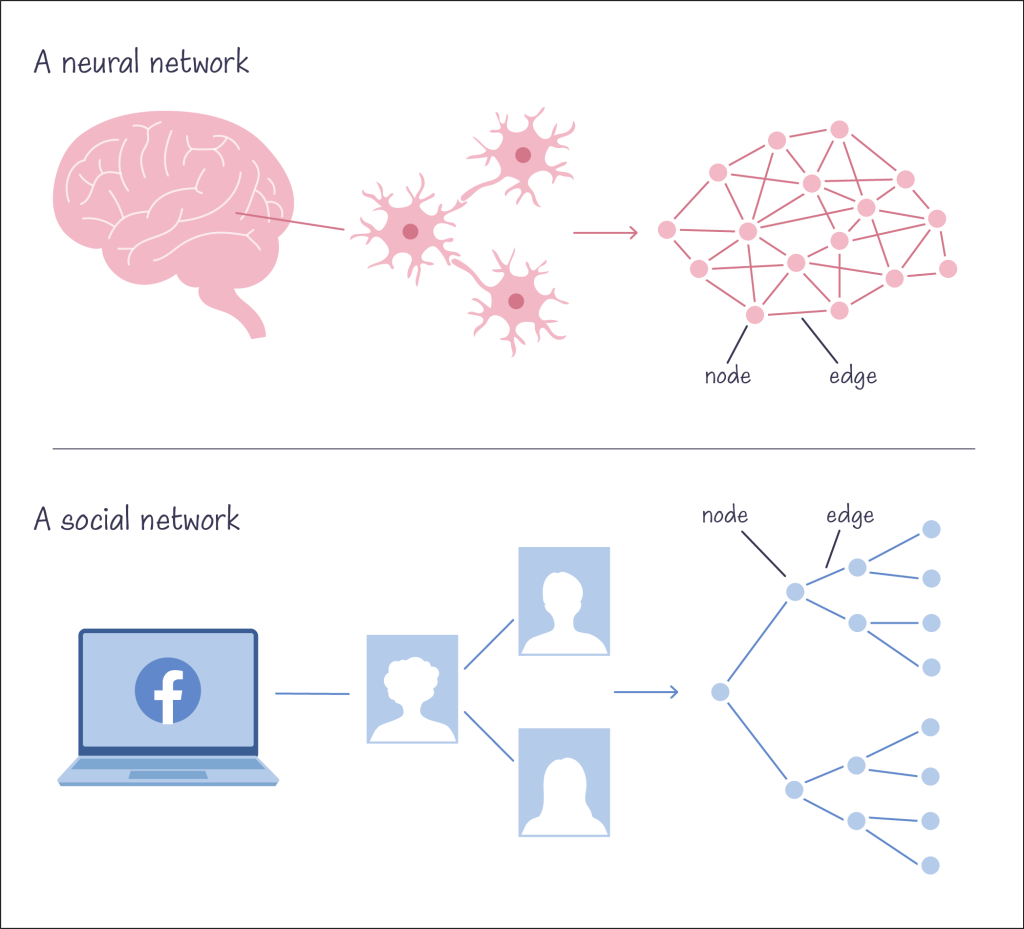

Within graph theory, we have a variety of different types of graphs:

* **Undirected Graph**: Edges do not have a direction associated with them.
* **Directed Graph**: Edges do have a direction associated with them.
* **Weighted Graph**: Where each edge has an associated weight or cost (e.g., distance).

See the graphical example below of these three types of graphs (Figures are credited to Haque and Andrejevic, 2021):

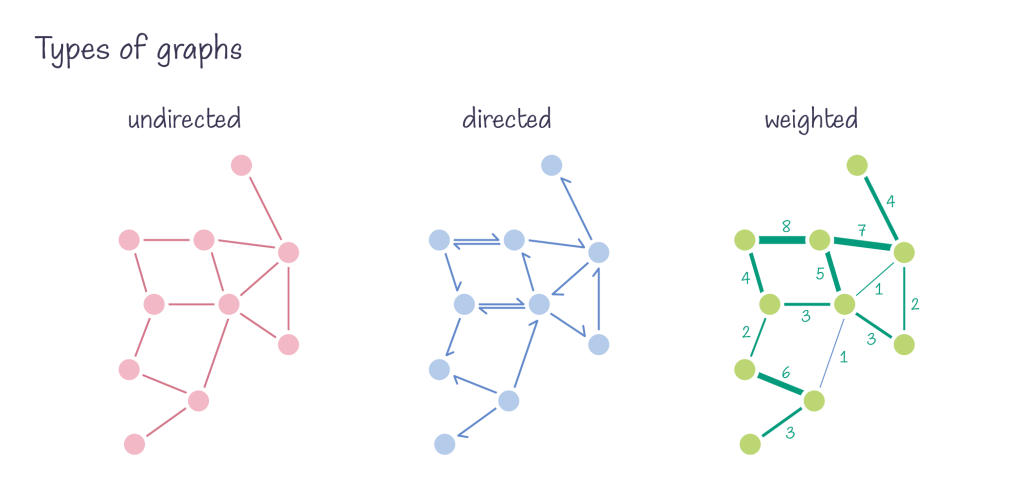

There are a range of algorithms which can be utilized to understand and traverse a graph. The Kruskal algorithm is one of many.

Our focus today is understanding how these types of techniques can be used to support modern mapping software, especially the navigation tools embedded within your smartphone, as well as infrastructure planning approaches.

In [ ]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/JZBQLXgSGfs?si=cBUswiVWRNaai3qm" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>')


In [ ]:
<iframe width="560" height="315" src="https://www.youtube.com/embed/EFg3u_E6eHU?si=38RtZ8Mn_AW5Wrb3" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

We can begin by loading in the `botswana_settlements.shp` data, which you can download from the MyMason BB page (see Course Content), followed by unzipping.



In [ ]:
from google.colab import files
files.upload()

We can now load in our node data for selected settlements in Botswana.

Please also view these in a piece of GIS software, e.g., QGIS.

In [ ]:
# Example: Load in our node data
import geopandas as gpd
from shapely.geometry import Point as shapely_point, LineString as shapely_linestring

# Load in using geopandas
nodes = gpd.read_file('botswana_settlements.shp', crs='epsg:4326')

# Convert to projected crs
nodes = nodes.to_crs('epsg:3857')
print(nodes.head(3)) # inspect geodataframe

# Convert our geodataframe to a list of dictionaries
nodes = nodes.to_dict('records')
print(nodes[0]) # inspect first dict

Next, we can specify all the possible edges in our network, creating a fully connected graph (e.g., connecting each node to all other nodes).

We will write these out as `my_edges.shp` so that you can view these in your GIS software.

We require this step to enable the mst algorithm to find the shortest path.

In [ ]:
# Example create a fully connected graph
my_edges = []

for item1 in nodes:
  for item2 in nodes:
    if item1['id'] != item2['id']:
      line = shapely_linestring([item1['geometry'], item2['geometry']])
      my_edges.append({
          'geometry': line,
          'properties': {
            'from': item1['id'],
            'to': item2['id'],
            'length': line.length
          }
      })

edges = gpd.GeoDataFrame.from_features(my_edges, crs='epsg:3857')
edges = edges.to_crs('epsg:4326')
edges.to_file('my_edges.shp', crs='epsg:4326')

Finally, we can utilize `NetworkX` to fit a minimum spanning tree, thanks to its handy `.minimum_spanning_edges()` function.

`NetworkX` provides a range of useful tools for creating, manipulating, and studying complex networks or graphs (including algorithms visualization capabilities etc.).

This `.minimum_spanning_edges()` function will iterate across all possible paths in the network that connect all points, and then rank these options, selecting the shortest distance instance as the minimum spanning tree.

In [ ]:
# Example: Fit our minimum spanning tree
import networkx as nx

G = nx.Graph()

for node_id, node in enumerate(nodes):
    G.add_node(node_id, object=node)

for edge in my_edges:
    G.add_edge(edge['properties']['from'], edge['properties']['to'],
        object=edge, weight=edge['properties']['length'])

tree = nx.minimum_spanning_edges(G)
print(tree) # inspect networkx generator object
print(list(tree)) #inspect underlying data structure

To export our minimum spanning tree, we will convert our tree from the format which `NetworkX` creates (source, sink, geometry), into a list of dictionaries, utilizing the geojson format.

We can then easily export this using `GeoPandas`.

In [ ]:
# Example: Export our minimum spanning tree

mst = []

# Convert our networkx mst into a geojson list of dicts
for source, sink, geojson in tree:
    if geojson['object']['properties']['length'] > 0:
        mst.append({
          'geometry': geojson['object']['geometry'],
          'properties': geojson['object']['properties']
        })

# Creat geodataframe
edges = gpd.GeoDataFrame.from_features(mst, crs='epsg:3857')

# Convert crs to export in 4326
edges = edges.to_crs('epsg:4326')

# Export to .shp file
edges.to_file('minimum_spanning_tree.shp', crs='epsg:4326')

Inspect the resulting files within your GIS software and think critically about the implications of using this type of approach for routing users and/or planning new infrastructure (e.g., roads, fiber optic links etc.)

Task

Go find the `botswana_settlements_task.zip` file from the MyMason Course Content page.

With this larger set of settlements, try to find a minimum spanning tree to connect all these nodes.

Once you have your results, think critically about how you could improve this.

Do you have the most cost-efficient network?

What could you do to reduce distance travelled/cost?


In [ ]:
# Enter your attempt below


Task

Find your own set of nodes, such as Points of Interest (PoIs), building centroids, electricity infrastructure etc. and fit a minimum spanning tree.

Prior to exporting your results, make sure you have the distance of each link, so that you can estimate the total distance covered in kilometers.

In [ ]:
# Enter your attempt below
